In [9]:
import os
from collections.abc import Iterator
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
from neuralop import H1Loss
from neuralop.models import FNO
from neuralop.training import Trainer
from sklearn.decomposition import PCA

from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../../config/plotting.yaml")

In [2]:
WORK = os.environ.get("WORK", "")
base_dir = f"{WORK}/physics-datasets"
re = 450
fpath = f"{base_dir}/von_karman_street/vortex_street_velocities_Re_{re}_4800timepoints.npz"

vfield = np.load(fpath, allow_pickle=True)
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]
vort_field_flattened = vort_field.reshape(vort_field.shape[0], -1)

In [3]:
n_components = 512
pca = PCA(n_components=n_components)
pca.fit(vort_field_flattened)
X_ts = pca.transform(vort_field_flattened)  # (T, D)
eigenvectors = pca.components_  # (D, H*W)

In [4]:
def reconstruct(pca_coeffs: np.ndarray, eigenvectors: np.ndarray, modes: int = -1) -> np.ndarray:
    if modes == -1:
        modes = pca_coeffs.shape[1]
    return pca_coeffs[:, :modes] @ eigenvectors[:modes, :]

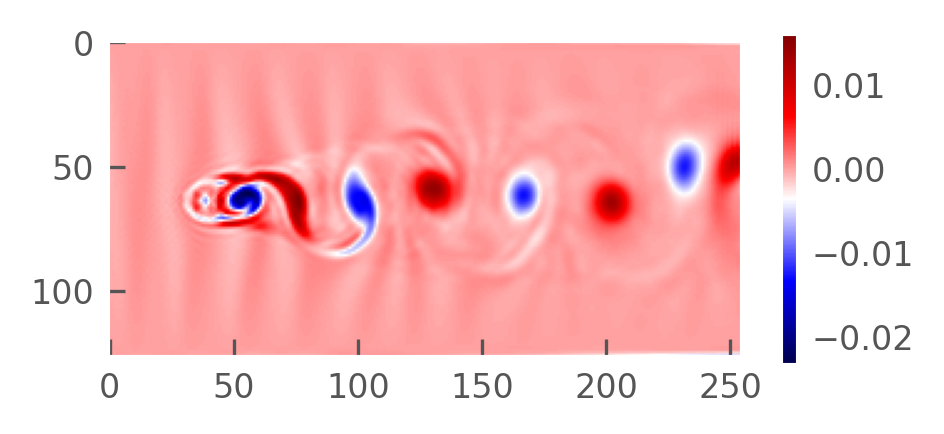

In [5]:
vort_recon = reconstruct(X_ts, eigenvectors)
vort_recon = vort_recon.reshape(vort_field.shape[0], vort_field.shape[1], vort_field.shape[2])
plt.figure()
plt.imshow(vort_recon[100 + 512, :, :].T, cmap="seismic")
plt.colorbar(shrink=0.5);

In [33]:
device_rank = 0
device = f"cuda:{device_rank}"

stride = 1
start = 2048  # ignore transient
context_length = 512
prediction_length = 128
end_time = context_length + prediction_length

lookback = 1

In [ ]:
@dataclass
class Dataset(torch.utils.data.Dataset):
    traj: torch.Tensor
    context_length: int = 1

    def __len__(self) -> int:
        return self.traj.shape[0] - self.context_length

    def __getitem__(self, idx: int) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        x = self.traj[idx : idx + self.context_length]
        y = self.traj[idx + self.context_length]
        if y.ndim == 1:
            y = y[np.newaxis, :]
        if x.ndim == 1:
            x = x[np.newaxis, :]
        return {
            "x": torch.from_numpy(x).float(),
            "y": torch.from_numpy(y).float(),
        }


strided_X = X_ts[start::stride]

context_window = strided_X[:context_length]
prediction_window = strided_X[context_length:end_time]

batch_size = 128
num_epochs = 2000

# preprocess training context
train_loader = torch.utils.data.DataLoader(
    Dataset(context_window, context_length=lookback),
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    Dataset(prediction_window, context_length=lookback), batch_size=batch_size, num_workers=0, pin_memory=True
)


operator = FNO(n_modes=(512,), hidden_channels=256, in_channels=lookback, out_channels=1).to(device)
trainer = Trainer(model=operator, n_epochs=num_epochs, verbose=True, device=device)
optimizer = torch.optim.AdamW(operator.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=(context_length - lookback) // batch_size * num_epochs
)
loss_fn = H1Loss(d=1)


class RelL2(torch.nn.Module):
    def __init__(self, eps=1e-12, reduction="mean"):
        super().__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, y_pred, y, **kwargs):
        gt = reconstruct(y, eigenvectors)
        pred = reconstruct(y, eigenvectors)
        num = torch.linalg.vector_norm(pred - gt, dim=tuple(range(1, y.ndim)))
        den = torch.linalg.vector_norm(gt, dim=tuple(range(1, y.ndim))).clamp_min(self.eps)
        rel = num / den
        return rel.mean() if self.reduction == "mean" else rel.sum()


trainer.train(
    train_loader=train_loader,
    test_loaders={"eval": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    training_loss=loss_fn,
    save_every=2000,
    save_dir="./vkvs_ckpt",
    save_best="eval_l2",
)

Training on 511 samples
Testing on [127] samples         on resolutions ['eval'].
Raw outputs of shape torch.Size([128, 1, 512])
[0] time=0.11, avg_loss=0.8326, train_err=106.3591
Eval: eval_l2=0.9229


/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1784: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/neuralop/training/trainer.py:536: UserWarning: H1Loss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[Rank 0]: saved training state to ./vkvs_ckpt
[1] time=0.12, avg_loss=0.6297, train_err=80.4392
Eval: eval_l2=0.6268
[Rank 0]: saved training state to ./vkvs_ckpt
[2] time=0.11, avg_loss=0.5822, train_err=74.3721
Eval: eval_l2=0.4608
[Rank 0]: saved training state to ./vkvs_ckpt
[3] time=0.12, avg_loss=0.4949, train_err=63.2195
Eval: eval_l2=0.4566
[Rank 0]: saved training state to ./vkvs_ckpt
[4] time=0.11, avg_loss=0.4713, train_err=60.2141
Eval: eval_l2=0.4839
[5] time=0.11, avg_loss=0.4620, train_err=59.0145
Eval: eval_l2=0.4628
[6] time=0.11, avg_loss=0.4579, train_err=58.5024
Eval: eval_l2=0.4455
[Rank 0]: saved training state to ./vkvs_ckpt
[7] time=0.11, avg_loss=0.4465, train_err=57.0450
Eval: eval_l2=0.4466
[8] time=0.11, avg_loss=0.4375, train_err=55.8916
Eval: eval_l2=0.4382
[Rank 0]: saved training state to ./vkvs_ckpt
[9] time=0.11, avg_loss=0.4303, train_err=54.9689
Eval: eval_l2=0.4224
[Rank 0]: saved training state to ./vkvs_ckpt
[10] time=0.12, avg_loss=0.4217, train_

{'train_err': 1.4158032834529877,
 'avg_loss': 0.011082608872430432,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.25288464594632387,
 'eval_l2': tensor(0.1298, device='cuda:0')}

In [46]:
def rollout(ic: torch.Tensor, num_steps: int, model: torch.nn.Module) -> torch.Tensor:
    traj = [ic]
    state = ic.clone()
    for _ in range(num_steps):
        pred = model(state)
        traj.append(pred)
        state = torch.cat([state[:, :-1, :], pred], dim=1)
    return torch.cat(traj, dim=1)

In [39]:
# load best model
WORK_DIR = os.path.expandvars("$WORK")
operator.load_state_dict(
    # torch.load(f"{WORK_DIR}/checkpoints/VKVS_baselines/best_model_state_dict.pt", map_location=device, weights_only=False)
    torch.load("vkvs_ckpt/best_model_state_dict.pt", map_location=device, weights_only=False)
)
operator.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([256, 256, 257]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
          (1): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 512, kernel_size=(1,), stride=(1,))
      (1): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (1): Conv1d(512, 1, k

In [47]:
prediction = (
    rollout(
        torch.from_numpy(context_window[-lookback:]).float().to(device).unsqueeze(0),
        model=operator,
        num_steps=prediction_length,
    )
    .squeeze()[lookback:]
    .detach()
    .cpu()
    .numpy()
)
prediction.shape

(128, 512)

In [48]:
def plot_predicted_flow(
    prediction: torch.Tensor,
    trajectory: torch.Tensor,
    eigenvectors: torch.Tensor,
    num_modes: int,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    time_indices: list[int] | None = None,
    save_path: str | None = None,
    stride: int = 1,
    cmap_name="seismic",
    base_figsize=(5, 5),
    suptitle: str | None = None,
    suptitle_y: float = 1.0,
    **kwargs,
):
    recon = reconstruct(prediction[:, :num_modes], eigenvectors, modes=num_modes)
    recon = recon.reshape(-1, shape[0], shape[1])
    groundtruth = reconstruct(trajectory[:, :num_modes], eigenvectors, modes=num_modes)
    groundtruth = groundtruth.reshape(-1, shape[0], shape[1])
    vabs = max(np.abs(groundtruth.min()), np.abs(groundtruth.max()))

    if time_indices is None:
        time_indices = list(range(0, groundtruth.shape[0], stride))

    aspect_ratio = shape[0] / shape[1]
    fig = plt.figure(
        figsize=(
            base_figsize[0] * (len(time_indices)) / aspect_ratio,
            base_figsize[1] * aspect_ratio,
        )
    )
    gs = fig.add_gridspec(
        2,
        len(time_indices),
        width_ratios=[1] * (len(time_indices)),
        height_ratios=[1, 1],
        wspace=0,
        hspace=0,
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(len(time_indices))] for i in range(2)])
    for i, index in enumerate(time_indices):
        groundtruth_slice = groundtruth[index, :, :]
        recon_slice = recon[index, :, :]

        gax = axes[0, i].imshow(
            groundtruth_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )

        axes[0, i].spines["top"].set_visible(True)
        axes[0, i].spines["right"].set_visible(True)
        axes[0, i].spines["bottom"].set_visible(True)
        axes[0, i].spines["left"].set_visible(True)
        axes[0, i].spines["top"].set_color("black")
        axes[0, i].spines["right"].set_color("black")
        axes[0, i].spines["bottom"].set_color("black")
        axes[0, i].spines["left"].set_color("black")

        axes[0, i].set_title(
            "t = context" + (f" + {index + 1}" if index > 0 else ""),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        rax = axes[1, i].imshow(
            recon_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )
        axes[1, i].spines["top"].set_visible(True)
        axes[1, i].spines["right"].set_visible(True)
        axes[1, i].spines["bottom"].set_visible(True)
        axes[1, i].spines["left"].set_visible(True)
        axes[1, i].spines["top"].set_color("black")
        axes[1, i].spines["right"].set_color("black")
        axes[1, i].spines["bottom"].set_color("black")
        axes[1, i].spines["left"].set_color("black")

        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[0, i].add_patch(circle)
        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[1, i].add_patch(circle)

    axes[0, 0].set_ylabel("Ground Truth", fontweight="bold", fontsize=16)
    axes[1, 0].set_ylabel("Predictions", fontweight="bold", fontsize=16)

    if suptitle is not None:
        plt.suptitle(suptitle, fontweight="bold", fontsize=18, ha="center", y=suptitle_y)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

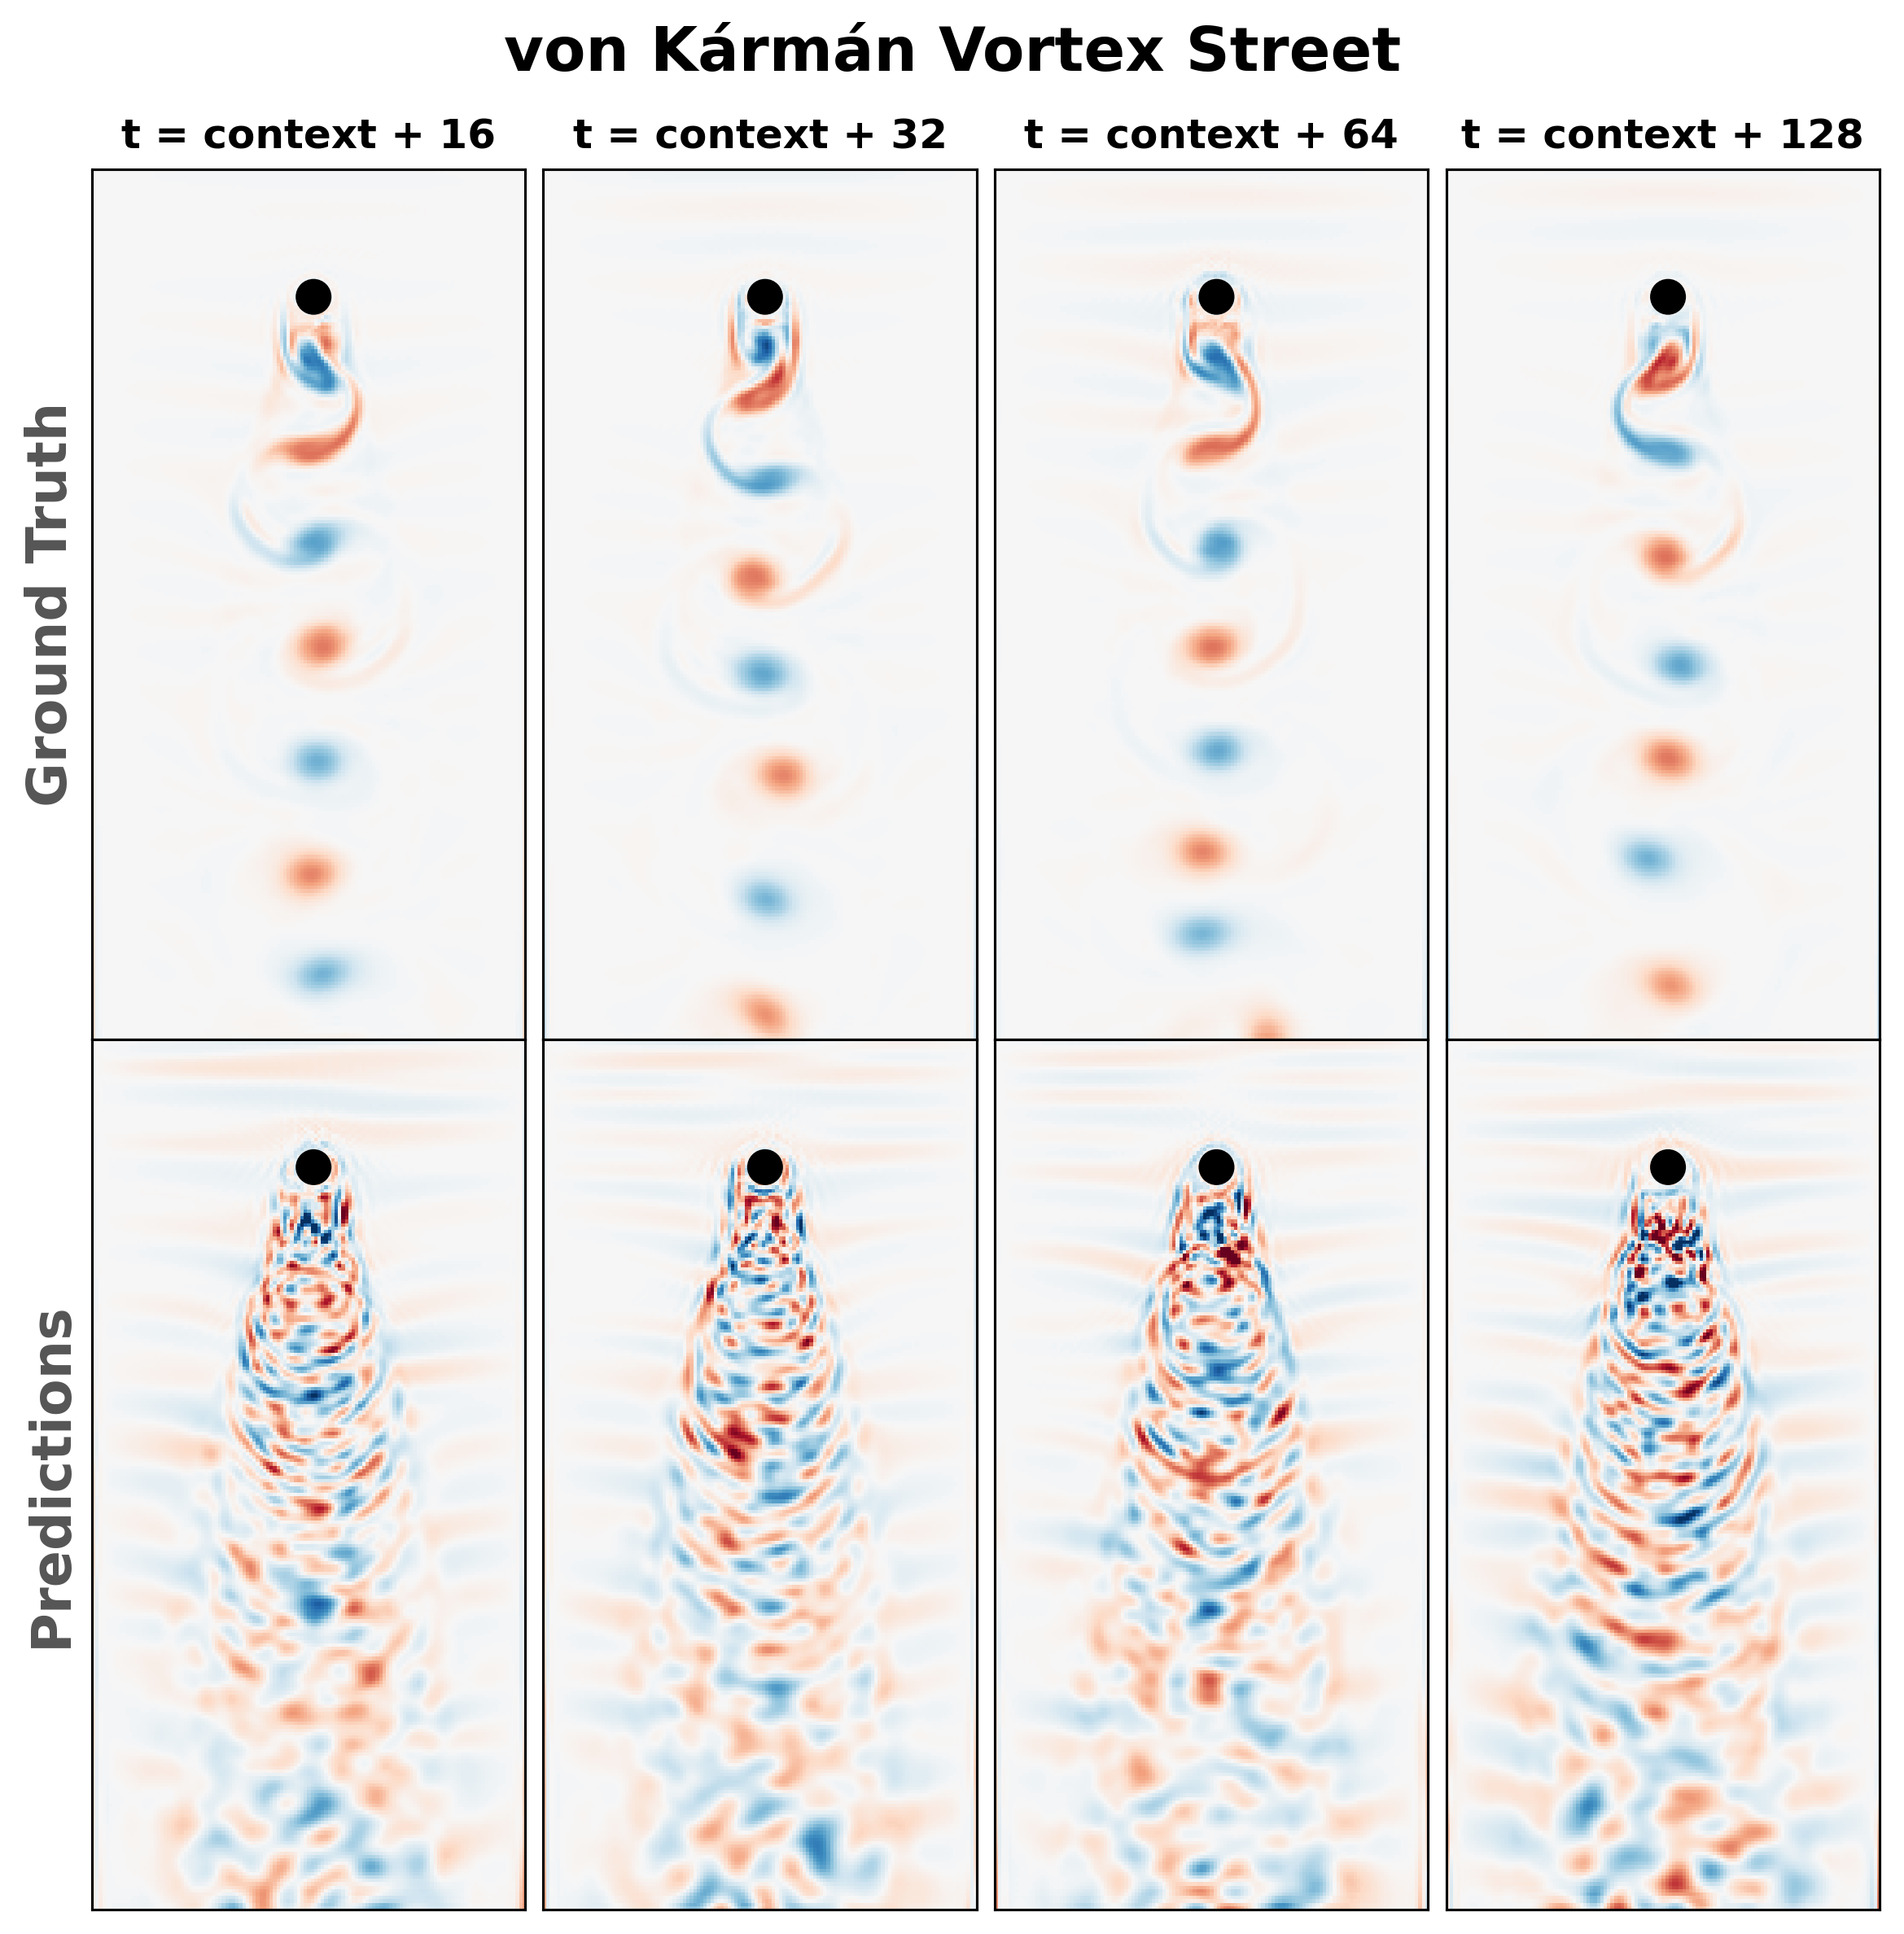

In [49]:
plot_predicted_flow(
    prediction,
    prediction_window,
    eigenvectors,
    num_modes=n_components,
    time_indices=[15, 31, 63, 127],
    cmap_name="RdBu",
    camera_ready=False,
    base_figsize=(4, 4),
    suptitle="von Kármán Vortex Street",
    suptitle_y=0.98,
)